# PROTOCOLO DE TELEPORTACION CUANTICA EN LA ESFERA DE BLOCH.

La teleportacion radica en el hecho de trasferir elmente un estado de un unico qubit (bit cuantico) entre dos partes, usualmente llamados Alice y Bob, empleando un par de qubits preparados en estado de Bell (maximamente entrelazados) que comparten las dos partes. En el protocolo reportado por Bennet et. al. Alice posee un estado cuantico  $\ket{\Psi}_{inicial} = \alpha \ket{0}+ \beta \ket{1}$ , donde $\alpha$ $\beta$ y son desconocidos para Alice. Adicionalmente, ella y Bob comparten el estado de Bell dado por,
   
<center>

$\ket{\Psi}_{+} = \frac{1}{\sqrt{2}}(\ket{0}_A\ket{0}_B + \ket{1}_A\ket{1}_B)$

</center>
Donde los subindices A y B indican si el qubit esta localizado en el subsistema de Alice o de Bob.

1) Se representa el estado inicial de Alice $\ket{\Psi}_{inicial}$ en la esfera de Bloch para 3 conjuntos de parametros, teniendo en cuenta que $|\alpha|^2+|\beta|^2=1$ para el estado normalizado.


    1. $\alpha=\sqrt{0.5}, \beta = \sqrt{0.5}$
    2. $\alpha=\sqrt{0.8}, \beta = \sqrt{0.2}$
    3. $\alpha=\sqrt{0.4}, \beta = \sqrt{0.6}$

In [4]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
from qiskit import transpile
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
from math import pi
from qiskit_ibm_runtime import QiskitRuntimeService


service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='dc31b03f027a9bd3feacb5714def6389cd678db34850e8cb6eb42805ecf2539fb88053c8adcf6224cba9c7cb1bca69fb9f0b3e11b2209c774fe42628b743f79f'
)


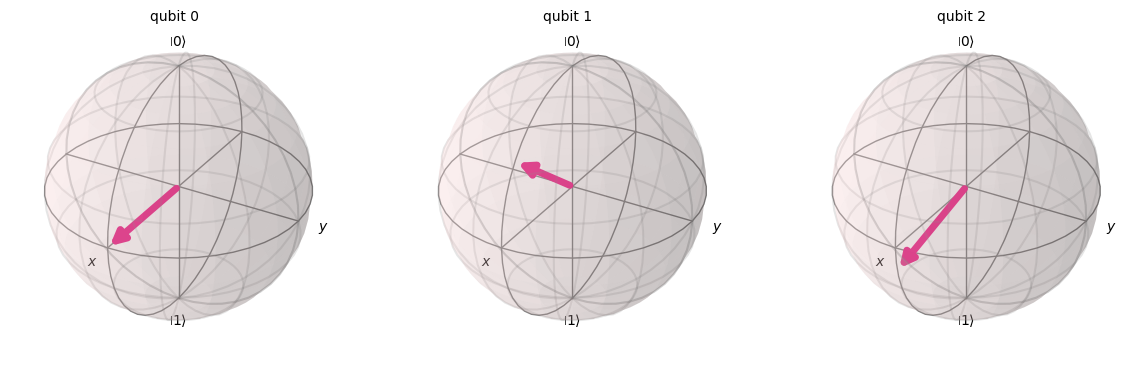

In [12]:
#Crear un circuito cuántico con 5 qubit
alice_inicial = QuantumCircuit(3)

# Inicializar el qubit en el estado |ψ⟩ = α|0⟩ + β|1⟩

alpha1 = (0.5)**0.5
beta1 = (0.5)**0.5

alpha2 = (0.8)**0.5
beta2 = (0.2)**0.5

alpha3 = (0.4)**0.5
beta3 = (0.6)**0.5


parametros = [[alpha1, beta1], [alpha2, beta2], [alpha3, beta3]]


for i in range(0,3):
    alice_inicial.initialize(parametros[i], i)


# Crear un Statevector solo para los tres primeros qubits
state = Statevector.from_instruction(alice_inicial)

# Dibujar el vector de estado en la esfera de Bloch
plot_bloch_multivector(state)

2. Obtener el estado cuantico compuesto de tres qubits de los subsistemas de Alice y Bob $\ket{\Psi}_{A,B}=\ket{\Psi_{inicial}}\otimes \ket{\Psi_{+}} $

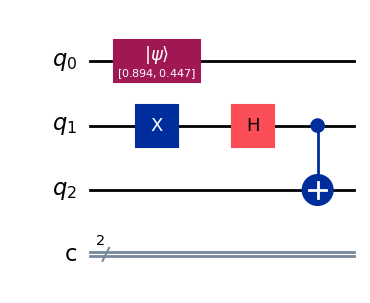

In [47]:
# Crear los 3 circuitos cuánticos
# Con 3 qubits y 2 bits clásicos para almacenar los resultados de las mediciones
qc = [QuantumCircuit(3, 2), QuantumCircuit(3, 2), QuantumCircuit(3, 2)] 


# Aplicar las puertas necesarias para crear un estado de Bell a cada circuito
for i in range(0,3):
    qc[i].initialize(parametros[i], 0)
    qc[i].x(1)
    qc[i].h(1)
    qc[i].cx(1, 2)





display(qc[1].draw(output='mpl'))

# Ejecutar el circuito en un simulador y obtener los resultados
simulator = Aer.get_backend('qasm_simulator')
circ = transpile(qc, simulator)
job = simulator.run(circ, shots=1000)
result = job.result()




# Mostrar los resultados de las mediciones en un histograma

# counts = result.get_counts()
# print(counts)
# plot_histogram(counts)

